In [ ]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torch.autograd import Variable

In [ ]:

def padding_func(input_tensor, padding):
  b, c, h, w = input_tensor.size()
  padded_width = torch.zeros(size = (b, c, padding, w))

  padded_tensor = torch.cat((input_tensor, padded_width), 2)
  padded_tensor = torch.cat((padded_width, padded_tensor), 2)

  padded_height = torch.zeros(size = (b, c, h + 2 * padding, padding))

  padded_tensor = torch.cat((padded_tensor, padded_height), 3)
  padded_tensor = torch.cat((padded_height, padded_tensor), 3)

  return padded_tensor


  
def unfold(input_tensor, padding, stride, k):

  b, c, h, w = input_tensor.size() # Extract batch_size, channels, height and width

  padded_tensor = padding_func(input_tensor, padding) # Pad the input tensor
  b, c, ph, pw = padded_tensor.size() # Get new height and width

  h_position = 0
  v_position = 0

  output_tensor = torch.empty(size = (b, k*k*c, 0)) # Empty tensor to append to

  while v_position <= ph - k: # Until we passed through all the rows (from top to bottom)

    subset = padded_tensor[:, :, v_position : v_position + k, h_position : h_position + k] # k is the kernel size
    flattened_subset = subset.flatten(start_dim = 1, end_dim = 3) # Flatten over channels, height and width
    output_tensor = torch.cat((output_tensor, flattened_subset[:,:, None]), 2) #Adding new axis to flattened tensor
    h_position += stride # Moving stride steps along the columns (horizontal)

    if h_position > pw - k: # If we reached the end of a row
      v_position += stride # Continue in next rows (with stride steps)
      h_position = 0 # Continue at the leftmost column
    
  return output_tensor


In [ ]:
padding = 1
stride = 2
k = 5
X = torch.rand(size = (32, 5, 5, 5)) #batch_size, channels, height, width
U = unfold(X, padding, stride, k)
U2 = F.unfold(X, k, 1, padding, stride)

print(U.size())
print(U2.size())
print(U == U2)

In [ ]:

def unpad(X: torch.tensor, padding: int):
    """
    This will remove the padding from the tensor X
    """
    _, _, y, x = X.shape
    return X[:,:,padding:y-padding, padding:x-padding]


def fold(U: torch.tensor, *, input_shape, padding, stride, k):
    b, c, y, x = input_shape
    padded_res = torch.empty((b, c, y+2*padding, x+2*padding))
    max_x_start = x+2*padding-k
    b, l, m = U.size()
    num_channels = int(l/(k*k))
    patch_shape = (b, num_channels, k, k)
    x, y = 0, 0
    for col_i in range(m):
        col = U[:,:,col_i]
        col = col.reshape(patch_shape)
        padded_res[:,:,y:y+k,x:x+k] += col
        x += stride
        if x > max_x_start:
            x = 0
            y += stride
    return unpad(padded_res, padding)


In [ ]:
def test():
    padding = 1
    stride = 3
    k = 5
    in_shape = (32, 10, 200, 100)
    X = torch.rand(size = in_shape) #batch_size, channels, height, width
    U = F.unfold(X, k, 1, padding, stride)
    refolded2 = F.fold(U, (200, 100), k, 1, padding, stride)
    refolded = fold(U, input_shape=X.size(), padding=padding, stride=stride, k=k)
    return refolded2, refolded

truth, test = test()

In [ ]:
truth == test

tensor([[[[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True]],

         [[True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          ...,
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ..., True, True, True],
          [True, True, True,  ...

In [ ]:
# Weight Tensor
W = torch.rand(size = (2, 125)) # Two Kernels, 27 parameters per Kernel

In [ ]:
# Forward from U to Y'
Y_prime =  W @ U # Matmul between W and U
Y_prime.size()

torch.Size([32, 2, 4])

In [ ]:
# Forward from Y' to Y
new_h = int(torch.sqrt(torch.tensor(Y_prime.size()[2])))
new_w = new_h

Y = Y_prime.reshape((32,2, new_h, new_w))
Y.size()

torch.Size([32, 2, 2, 2])

In [ ]:
# Backward wrt Y_prime

Y.reshape((32,2, new_h**2)).size()


torch.Size([32, 2, 4])

In [ ]:
# Backward wrt weight tensor (W)
(Y_prime @ torch.transpose(U, 2, 1)).size()

torch.Size([32, 2, 125])

In [ ]:
# Backward wrt unfolded patches (U)
(torch.transpose(W, 1, 0) @ U).size()

RuntimeError: ignored

In [ ]:
# Backward wrt raw input (X)

# Dimension of X: (32, 3, 5, 5)
# Dimension of U: (32, 27, 9)
# Needed: kernel_size, padding, stride


### Question 6

In [ ]:
def pad(X: torch.tensor, padding: int):
    b, c, h, w = X.size()
    padded_width = torch.zeros(size = (b, c, padding, w))

    padded_tensor = torch.cat((X, padded_width), 2)
    padded_tensor = torch.cat((padded_width, padded_tensor), 2)

    padded_height = torch.zeros(size = (b, c, h + 2 * padding, padding))

    padded_tensor = torch.cat((padded_tensor, padded_height), 3)
    padded_tensor = torch.cat((padded_height, padded_tensor), 3)

    return padded_tensor

def unfold(X: torch.tensor, k: int, padding: int, stride: int):
    b, c, _, _ = X.size() # Extract batch_size, channels, height and width

    padded_tensor = pad(X, padding) # Pad the input tensor
    b, c, ph, pw = padded_tensor.size() # Get new height and width

    h_position = 0
    v_position = 0

    output_tensor = torch.empty(size = (b, k*k*c, 0)) # Empty tensor to append to

    while v_position <= ph - k: # Until we passed through all the rows (from top to bottom)

        subset = padded_tensor[:, :, v_position : v_position + k, h_position : h_position + k] # k is the kernel size
        flattened_subset = subset.flatten(start_dim = 1, end_dim = 3) # Flatten over channels, height and width
        output_tensor = torch.cat((output_tensor, flattened_subset[:,:, None]), 2) #Adding new axis to flattened tensor
        h_position += stride # Moving stride steps along the columns (horizontal)

        if h_position > pw - k: # If we reached the end of a row
            v_position += stride # Continue in next rows (with stride steps)
            h_position = 0 # Continue at the leftmost column
        
    return output_tensor


def unpad(X: torch.tensor, padding: int):
    """
    This will remove the padding from the tensor X
    """
    _, _, y, x = X.shape
    return X[:,:,padding:y-padding, padding:x-padding]

def fold(U: torch.tensor, *, input_shape, padding, stride, k):
    b, c, y, x = input_shape
    padded_res = torch.empty((b, c, y+2*padding, x+2*padding))
    max_x_start = x+2*padding-k
    b, l, m = U.size()
    num_channels = int(l/(k*k))
    patch_shape = (b, num_channels, k, k)
    x, y = 0, 0
    for col_i in range(m):
        col = U[:,:,col_i]
        col = col.reshape(patch_shape)
        padded_res[:,:,y:y+k,x:x+k] += col
        x += stride
        if x >= max_x_start:
            x = 0
            y += stride
    return unpad(padded_res, padding)

def new_size(cur_size, padding, kernel, stride):
    return int((cur_size + 2*padding - kernel)/stride) + 1

class Conv2D(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1, weights = None):
        super().__init__()

        if weights is None:
          self.weights = torch.rand((out_channels, in_channels*kernel_size[0]*kernel_size[1]))
        else:
          self.weights = weights

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, input_batch):
        b, _, h, w = input_batch.size()
        U = unfold(input_batch, self.kernel_size[0], self.padding, self.stride)
        Y = self.weights @ U
        newh = new_size(h, self.padding, self.kernel_size[0], self.stride)
        neww = new_size(w, self.padding, self.kernel_size[1], self.stride)
        new_shape = (b, self.out_channels, newh, neww)
        Y = Y.reshape(new_shape)
        return Y


class CustomConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1):
        super().__init__()
        self.weights = torch.rand((out_channels, in_channels*kernel_size[0]*kernel_size[1]))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, input_batch):
        b, _, h, w = input_batch.size()
        U = F.unfold(input_batch, self.kernel_size, 1, self.padding, self.stride)
        Y = self.weights @ U
        Y2 = U.transpose(1, 2).matmul(self.weights.view(self.weights.size(0), -1).t()).transpose(1, 2)
        newh = new_size(h, self.padding, self.kernel_size[0], self.stride)
        neww = new_size(w, self.padding, self.kernel_size[1], self.stride)
        return F.fold(Y, (newh, neww), (1,1)), F.fold(Y2, (newh, neww), (1, 1))


class CustomConv2dEx(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=(3,3), stride=1, padding=1):
        super().__init__()
        self.weights = torch.rand((out_channels, in_channels*kernel_size[0]*kernel_size[1]))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

    def forward(self, input_batch):
        b, _, h, w = input_batch.size()
        weights = self.weights
        inp_unf = torch.nn.functional.unfold(input_batch, (3,3), 1, self.padding, self.stride)
        out_unf = inp_unf.transpose(1, 2).matmul(weights.view(weights.size(0), -1).t()).transpose(1, 2)
        newh = new_size(h, self.padding, self.kernel_size[0], self.stride)
        neww = new_size(w, self.padding, self.kernel_size[1], self.stride)
        return torch.nn.functional.fold(out_unf, (newh, neww), (1, 1))


def test_module(X):
    torch.manual_seed(0)
    real_conv = torch.nn.Conv2d(5, 10, (3,3), 1, 1, 1, 1, False)
    initial_weights = conv.weight.clone().detach()
    #fake_conv = Conv2D(5, 10, (3,3), 1, 1, weights = initial_weights)
    fake_conv = Conv2D(5, 10, (3,3), 1, 1)
    cust = CustomConv2d(5, 10, padding=1)
    my_conv = CustomConv2dEx(5, 10, padding=1)

    rc_params = real_conv.parameters(recurse=False)
    rc_weights = next(rc_params)
    fake_conv.weights = rc_weights.reshape((10, 45))
    cust.weights = rc_weights.reshape((10, 45))
    my_conv.weights = rc_weights.reshape((10, 45))

    #X = torch.rand((13, 5, 10, 20))
    our_out = fake_conv(X)
    realconv = real_conv(X)
    custconv1 = cust(X)
    mycov = my_conv(X)

    return our_out, realconv

In [ ]:
conv = torch.nn.Conv2d(5, 10, (3,3), 1, 1, 1, 1, False)

weights = conv.weight.clone().detach()

In [ ]:
X = torch.rand((13, 5, 10, 20))


In [ ]:
x,y = test_module(X)

x == y

tensor([[[[False, False,  True,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ...,  True,  True,  True],
          ...,
          [ True, False, False,  ..., False,  True, False],
          [ True,  True, False,  ..., False, False,  True],
          [ True, False, False,  ..., False, False, False]],

         [[False,  True,  True,  ..., False, False, False],
          [ True,  True,  True,  ..., False, False, False],
          [ True, False, False,  ..., False, False,  True],
          ...,
          [False, False, False,  ..., False, False, False],
          [False,  True, False,  ...,  True, False, False],
          [False, False, False,  ..., False, False, False]],

         [[ True, False, False,  ..., False, False,  True],
          [False, False, False,  ..., False, False,  True],
          [False, False, False,  ..., False, False, False],
          ...,
          [False,  True, False,  ...,  True, False,

# Part 2: Simple CNN for MNIST Data 

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels = 1):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels= in_channels,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv3 to (batch_size, 64 * 3 * 3)
        x = x.view(x.size(0), -1)   
        output = self.out(x)
        return output

In [ ]:
# data download
train = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
test_set = torchvision.datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())
# split train:val 5:1, different dataset need to adjust the parameter

BATCH_SIZE = 16

train_set, val_set = torch.utils.data.random_split(train, [50000,10000])
trainloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,shuffle=True, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    
    loss_list = []
    size = len(dataloader.dataset)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # train_gen = datagen.flow(X, y, batch_size=128)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return model, loss_list


def valid(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0.0, 0.0
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # valid_gen = datagen.flow(X, y, batch_size=128)
        pred = model(X)
        loss += loss_fn(pred, y).item()
        
        pred = pred.data.max(1, keepdim=True)[1]
        correct += pred.eq(y.data.view_as(pred)).cpu().sum()
        loss /= len(dataloader.dataset)
        if batch % 1000 == 0:
            print("Average Val Loss: {:.6f}, Val Accuracy: {}/{}({:.6f}%)".format(
            loss, correct, size, 100. * (correct / size)))
            

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, correct = 0.0, 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # test_gen = datagen.flow(X, y, batch_size=128)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {loss:>8f} \n")

In [ ]:
model = CNN()

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    model, loss_list = train(trainloader, model, loss_fn, optimizer)
    test(testloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.309810  [    0/50000]
loss: 0.051164  [32000/50000]
Test Error: 
 Accuracy: 98.02000%, Avg loss: 0.059914 

Epoch 2
-------------------------------
loss: 0.037294  [    0/50000]
loss: 0.027106  [32000/50000]
Test Error: 
 Accuracy: 98.49000%, Avg loss: 0.047301 

Epoch 3
-------------------------------
loss: 0.015559  [    0/50000]
loss: 0.000746  [32000/50000]
Test Error: 
 Accuracy: 98.95000%, Avg loss: 0.031035 

Epoch 4
-------------------------------
loss: 0.015385  [    0/50000]
loss: 0.001553  [32000/50000]
Test Error: 
 Accuracy: 99.02000%, Avg loss: 0.029417 

Epoch 5
-------------------------------
loss: 0.084200  [    0/50000]
loss: 0.059354  [32000/50000]
Test Error: 
 Accuracy: 99.02000%, Avg loss: 0.030816 

Done!


## Tuning Hyperparameter for the basic CNN

In [ ]:
# Tune Hyperparameters for Q8
epochs = 5

for lr, bs in ((0.0005, 16), (0.0005, 32), (0.001, 16), (0.001, 32), (0.003, 16), (0.003, 32), (0.005, 16), (0.005, 32), (0.01, 16), (0.01, 32)):
  trainloader = torch.utils.data.DataLoader(train_set, batch_size=bs,shuffle=True, num_workers=2)
  validloader = torch.utils.data.DataLoader(val_set, batch_size=bs,shuffle=True, num_workers=2)
  testloader = torch.utils.data.DataLoader(test_set, batch_size=bs,shuffle=True, num_workers=2)

  model = CNN()
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  loss_fn = nn.CrossEntropyLoss()

  loss_list = []
  size = len(trainloader.dataset)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  for t in range(epochs):
    
    for batch, (X, y) in enumerate(trainloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  with open(f'loss_list_{lr}_ {bs}_basicCNN.pkl', 'wb') as f:
    pickle.dump(loss_list, f)

  # Save Net
  PATH = f'./{lr}_{bs}_net_basicCNN.pth'
  torch.save(model.state_dict(), PATH)

  print(f"Test performance for learning rate of {lr} and batch size {bs}")    
  test(testloader, model, loss_fn)



loss: 2.294476  [    0/50000]
loss: 0.064826  [16000/50000]
loss: 0.020771  [32000/50000]
loss: 0.002228  [48000/50000]
loss: 0.292926  [    0/50000]
loss: 0.003000  [16000/50000]
loss: 0.026307  [32000/50000]
loss: 0.002110  [48000/50000]
loss: 0.002446  [    0/50000]
loss: 0.000399  [16000/50000]
loss: 0.020275  [32000/50000]
loss: 0.028310  [48000/50000]
loss: 0.005113  [    0/50000]
loss: 0.055475  [16000/50000]
loss: 0.000516  [32000/50000]
loss: 0.023063  [48000/50000]
loss: 0.039185  [    0/50000]
loss: 0.004931  [16000/50000]
loss: 0.016566  [32000/50000]
loss: 0.001773  [48000/50000]
Test performance for learning rate of 0.0005 and batch size 16
Test Error: 
 Accuracy: 98.96000%, Avg loss: 0.034951 

loss: 2.302004  [    0/50000]
loss: 0.122064  [32000/50000]
loss: 0.056191  [    0/50000]
loss: 0.078988  [32000/50000]
loss: 0.014390  [    0/50000]
loss: 0.047195  [32000/50000]
loss: 0.302025  [    0/50000]
loss: 0.002701  [32000/50000]
loss: 0.017530  [    0/50000]
loss: 0.001

<function matplotlib.pyplot.show(*args, **kw)>

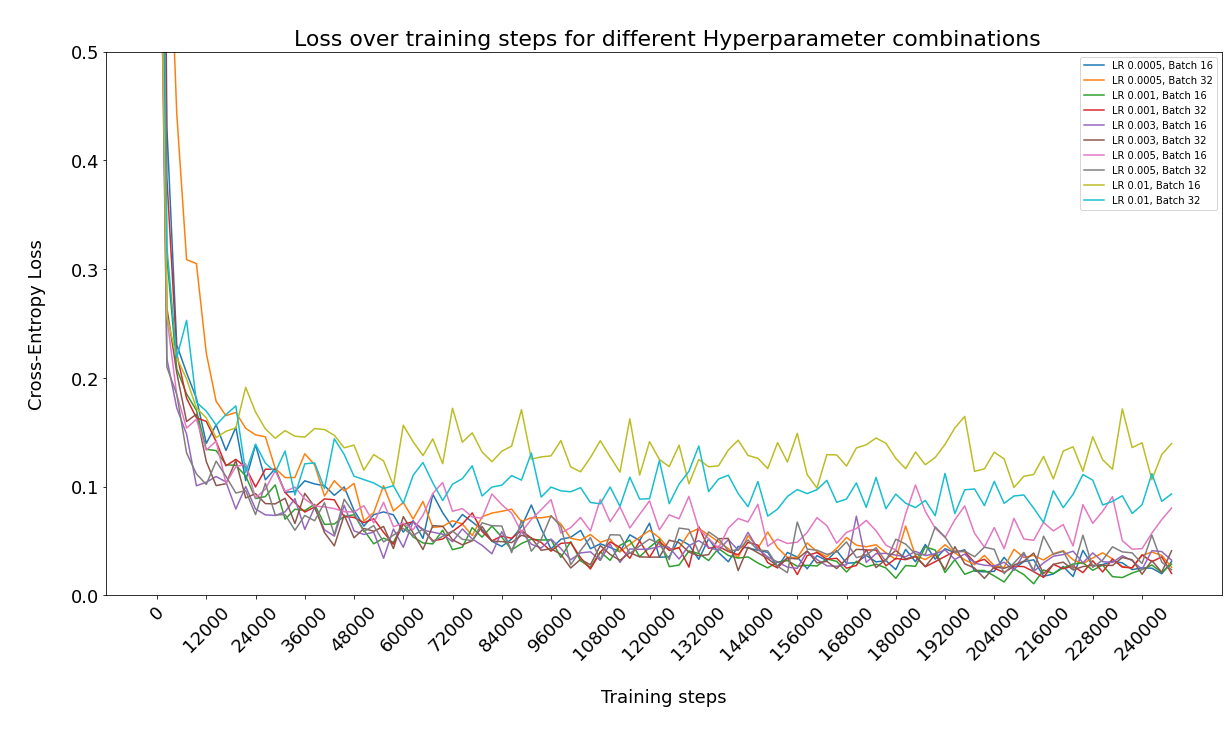

In [ ]:
epochs = 5
window_size = 150

loss_histories = []
for lr, bs in ((0.0005, 16), (0.0005, 32), (0.001, 16), (0.001, 32), (0.003, 16), (0.003, 32), (0.005, 16), (0.005, 32), (0.01, 16), (0.01, 32)):
    with open (f'loss_list_{lr}_ {bs}_basicCNN.pkl', 'rb') as f:
        loss_history = pickle.load(f)
    if bs == 32:
      loss_history = [val for val in loss_history for _ in (0, 1)]
    windows = [loss_history[i:i+window_size] for i in range(0,len(loss_history)-window_size,window_size)]
    loss_avg = [sum(window)/window_size for window in windows]
    loss_histories.append(loss_avg)
    
plt.figure(figsize=(20,10))
plt.plot(loss_histories[0],label = "LR 0.0005, Batch 16")
plt.plot(loss_histories[1],label = "LR 0.0005, Batch 32")
plt.plot(loss_histories[2],label = "LR 0.001, Batch 16")
plt.plot(loss_histories[3],label = "LR 0.001, Batch 32")
plt.plot(loss_histories[4],label = "LR 0.003, Batch 16")
plt.plot(loss_histories[5],label = "LR 0.003, Batch 32")
plt.plot(loss_histories[6],label = "LR 0.005, Batch 16")
plt.plot(loss_histories[7],label = "LR 0.005, Batch 32")
plt.plot(loss_histories[8],label = "LR 0.01, Batch 16")
plt.plot(loss_histories[9],label = "LR 0.01, Batch 32")
plt.legend()
ticks = [round(i/window_size) for i in range(0, len(loss_history) + 1, window_size*epochs)]
plt.xticks(ticks = ticks, labels = [tick * window_size * 16 for tick in ticks], size = 18, rotation = 45)
plt.yticks(size = 18)
plt.ylim(0, 0.5)
plt.title("\n Loss over training steps for different Hyperparameter combinations", size = 22)
plt.ylabel("\nCross-Entropy Loss\n", size = 18)
plt.xlabel("\nTraining steps\n", size = 18)
plt.legend()
plt.show


## Testing the best model from Hyperparameter Tuning on the validation set

In [ ]:

loss_fn = nn.CrossEntropyLoss()
 
#Load Best Model for validation
PATH = f'./{0.001}_{32}_net_basicCNN.pth'
best_model = CNN()
best_model.load_state_dict(torch.load(PATH))

dataloader = validloader 
size = len(dataloader.dataset)
num_batches = len(dataloader)
model.eval()
loss, correct = 0.0, 0.0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
loss /= num_batches
correct /= size
print(f"Validation Error: \n Accuracy: {(100*correct):>0.5f}%, Avg loss: {loss:>8f} \n")
            

Validation Error: 
 Accuracy: 96.93000%, Avg loss: 0.102852 



## Data Augmentation 

In [ ]:

transform_augment = T.Compose([T.RandomHorizontalFlip(0.3), 
                             T.RandomVerticalFlip(0.3),
                             T.RandomRotation(degrees=58),
                             T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                             T.ToTensor()])

augmented_train_set = torchvision.datasets.MNIST(root='data', train=True, download=True, transform = transform_augment)
augmented_trainloader = torch.utils.data.DataLoader(augmented_train_set, batch_size=32,shuffle=True, num_workers=2)
dataloader = augmented_trainloader
model = CNN()

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.CrossEntropyLoss()

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_list = []
    size = len(dataloader.dataset)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())

test(testloader, model, loss_fn)

    

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Test Error: 
 Accuracy: 91.33000%, Avg loss: 0.277735 



In [4]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

from torchvision.transforms import ToTensor
from torch.autograd import Variable

# Part 3: Variable Resolution Networks


In [5]:
# Defining the basic CNN from part 2 (see notebook for part 1 and 2)

class CNN(nn.Module):
    def __init__(self, in_channels = 1):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels= in_channels,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels=32,              
                out_channels=64,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(64 * 3 * 3, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # flatten the output of conv3 to (batch_size, 64 * 3 * 3)
        x = x.view(x.size(0), -1)   
        output = self.out(x)
        return output
    

## Q11

In [ ]:
# Q11
X = torch.rand(size = (32, 3, 5, 5)) #batch_size, channels, height, width

# Global Max Pool
globalmaxpool = torch.squeeze(F.max_pool2d(X, kernel_size= X.size()[2:]))

# Global Mean Pool
globalmeanpool = torch.squeeze(F.avg_pool2d(X, kernel_size= X.size()[2:]))

# Check dims
assert globalmaxpool.size() == X.size()[:2]
assert globalmeanpool.size()  == X.size()[:2]

## Q12

In [4]:
# Q12

transform = T.Compose(
    [T.Resize(size = (28,28)),
     T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

lowres_trainset = torchvision.datasets.ImageFolder("/Users/maxfeucht/Documents/VU/Deep Learning/Assignments/Assignment3/mnist-varres/train", transform = transform)
lowres_testset = torchvision.datasets.ImageFolder("/Users/maxfeucht/Documents/VU/Deep Learning/Assignments/Assignment3/mnist-varres/test", transform = transform)

lowres_trainloader = torch.utils.data.DataLoader(lowres_trainset, batch_size=16, shuffle=True, num_workers=4)
lowres_testloader = torch.utils.data.DataLoader(lowres_testset, batch_size=16, shuffle=True, num_workers=4)


In [6]:
batch_size = 16
epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CNN from part 2
net = CNN(in_channels = 3)
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

size = len(lowres_trainset)
loss_list = []
running_total, running_correct = 0,0

for e in range(epochs): 

  for batch, (inputs, labels) in enumerate(lowres_trainloader):
    inputs, labels = inputs.to(device), labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())
    loss.backward()
    optimizer.step()

    # Check performance
    _, predicted = torch.max(outputs.data, 1)
    running_total += labels.size(0)
    running_correct += (predicted == labels).sum().item()

    if batch % 100 == 0: # Print every 10 batches
          current = batch * len(labels)
          print(f"loss: {loss:>7f}, accuracy: {running_correct / running_total :>5f} [{current:>5d}/{size:>5d}]")


loss: 2.308976, accuracy: 0.125000 [    0/60000]
loss: 2.001901, accuracy: 0.173886 [ 1600/60000]
loss: 1.286560, accuracy: 0.335821 [ 3200/60000]
loss: 0.970150, accuracy: 0.431894 [ 4800/60000]
loss: 0.943225, accuracy: 0.495012 [ 6400/60000]
loss: 1.097198, accuracy: 0.546532 [ 8000/60000]
loss: 0.716549, accuracy: 0.587874 [ 9600/60000]
loss: 0.803554, accuracy: 0.617511 [11200/60000]
loss: 0.294618, accuracy: 0.643571 [12800/60000]
loss: 0.536488, accuracy: 0.665719 [14400/60000]
loss: 0.245715, accuracy: 0.685252 [16000/60000]
loss: 0.255519, accuracy: 0.700783 [17600/60000]
loss: 0.099699, accuracy: 0.715602 [19200/60000]
loss: 0.442221, accuracy: 0.728526 [20800/60000]
loss: 0.150479, accuracy: 0.740542 [22400/60000]
loss: 0.325125, accuracy: 0.750958 [24000/60000]
loss: 0.284803, accuracy: 0.760579 [25600/60000]
loss: 0.470561, accuracy: 0.769364 [27200/60000]
loss: 0.260535, accuracy: 0.777415 [28800/60000]
loss: 0.211870, accuracy: 0.783930 [30400/60000]
loss: 0.150169, accu

In [11]:
## Defining a function to test the fixed resolution model

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, correct = 0.0, 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            # test_gen = datagen.flow(X, y, batch_size=128)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {loss:>6f} \n")


test(lowres_testloader, net, criterion)

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.079325 



## Q14: Load variable resolution data

In [2]:
# Loading variable resolution Training Data

transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

varres_trainset = torchvision.datasets.ImageFolder("/Users/maxfeucht/Documents/VU/Deep Learning/Assignments/Assignment3/mnist-varres/train", transform = transform)

varres_trainloader = torch.utils.data.DataLoader(varres_trainset, batch_size=1, shuffle=True, num_workers=4)

# Loop over images and add them to the correct tensor according to their size
imgs_32 = torch.empty(0,3,32,32) 
imgs_48 = torch.empty(0,3,48,48) 
imgs_64 = torch.empty(0,3,64,64) 
labels_32 = torch.empty(0) 
labels_48 = torch.empty(0) 
labels_64 = torch.empty(0) 

for img, label in tqdm(varres_trainloader):

  if img.size()[3] == 32:
    imgs_32 = torch.cat((imgs_32, img), 0)
    labels_32 = torch.cat((labels_32, label), 0)
  elif img.size()[3] == 48:
    imgs_48 = torch.cat((imgs_48, img), 0)
    labels_48 = torch.cat((labels_48, label), 0)
  elif img.size()[3] == 64:
    imgs_64 = torch.cat((imgs_64, img), 0)
    labels_64 = torch.cat((labels_64, label), 0)
    
labels_32 = labels_32.type(torch.LongTensor)
labels_48 = labels_48.type(torch.LongTensor)
labels_64 = labels_64.type(torch.LongTensor)

100%|██████████| 60000/60000 [1:51:41<00:00,  8.95it/s]  


In [3]:
# Loading variable resolution Testing Data

transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

varres_testset = torchvision.datasets.ImageFolder("/Users/maxfeucht/Documents/VU/Deep Learning/Assignments/Assignment3/mnist-varres/test", transform = transform)

varres_testloader = torch.utils.data.DataLoader(varres_testset, batch_size=1, shuffle=True, num_workers=4)

# Loop over images and add them to the correct tensor according to their size
test_imgs_32 = torch.empty(0,3,32,32) 
test_imgs_48 = torch.empty(0,3,48,48) 
test_imgs_64 = torch.empty(0,3,64,64) 
test_labels_32 = torch.empty(0) 
test_labels_48 = torch.empty(0) 
test_labels_64 = torch.empty(0) 

for img, label in tqdm(varres_testloader):

  if img.size()[3] == 32:
    test_imgs_32 = torch.cat((test_imgs_32, img), 0)
    test_labels_32 = torch.cat((test_labels_32, label), 0)
  elif img.size()[3] == 48:
    test_imgs_48 = torch.cat((test_imgs_48, img), 0)
    test_labels_48 = torch.cat((test_labels_48, label), 0)
  elif img.size()[3] == 64:
    test_imgs_64 = torch.cat((test_imgs_64, img), 0)
    test_labels_64 = torch.cat((test_labels_64, label), 0)

test_labels_32 = test_labels_32.type(torch.LongTensor)
test_labels_48 = test_labels_48.type(torch.LongTensor)
test_labels_64 = test_labels_64.type(torch.LongTensor)


100%|██████████| 10000/10000 [03:39<00:00, 45.54it/s] 


## Q14: Defining a variable resolution network

In [2]:
# Q 13 - 16: Variable Resolution Network

class Varres_Net(nn.Module):
    def __init__(self, N, in_channels = 1, global_pool = "max"):
        super().__init__()
        self.global_pool = global_pool
        self.conv1 = nn.Conv2d(in_channels, 16, 3, padding = "same", stride = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = "same", stride = 1)
        self.conv3 = nn.Conv2d(32, N, 3, padding = "same", stride = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(N, 10)

    def forward(self, x):

        # 3 Conv Layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Global Pooling
        if self.global_pool == "max":
          x = torch.squeeze(F.max_pool2d(x, kernel_size = x.size()[2:]))
        elif self.global_pool == "avg":
          x = torch.squeeze(F.avg_pool2d(x, kernel_size = x.size()[2:]))

        # FC Layer
        x = self.fc(x)

        return x

N = 80
net = Varres_Net(N)



## Q15: Finding N

In [7]:

from torchsummary import summary

for N in (64, 80, 96, 112, 128, 144, 160, 176, 192, 204, 220, 236, 252, 264):
  net = Varres_Net(N)
  summary(net, (1,16,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             160
         MaxPool2d-2             [-1, 16, 8, 8]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
         MaxPool2d-4             [-1, 32, 4, 4]               0
            Conv2d-5             [-1, 64, 4, 4]          18,496
         MaxPool2d-6             [-1, 64, 2, 2]               0
            Linear-7                   [-1, 10]             650
Total params: 23,946
Trainable params: 23,946
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.09
Estimated Total Size (MB): 0.16
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output S

In [37]:
# Training over all three datasets with different resolutions

N = 80 
batch_size = 16
epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


for pool_option in ("max", "avg"):

  net = Varres_Net(N, in_channels = 3, global_pool = pool_option)
  net.to(device)
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001)

  running_correct = 0
  running_total = 0
  loss_list = []

  # Loop over variable resolutions
  for e in range(epochs):
    
    len_32, len_48, len_64 = len(imgs_32), len(imgs_48), len(imgs_64)
    size = len_32 + len_48 + len_64
    
    for batch in range(0, size, batch_size):
      
      # Select from correct Tensor according to iteration
      if batch < len_32:
        subset = batch
        imgs = imgs_32[subset : subset + batch_size,:,:,:]
        labels = labels_32[subset : subset + batch_size]
      elif batch >= len_32 and batch < len_32 + len_48:
        subset = batch - len_32
        imgs = imgs_48[subset : subset + batch_size,:,:,:]
        labels = labels_48[subset : subset + batch_size]
      elif batch >= len_32 + len_48 and batch < size:
        subset = batch - len_32 - len_48
        imgs = imgs_64[subset : subset + batch_size,:,:,:]
        labels = labels_64[subset : subset + batch_size]

      imgs, labels = imgs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(imgs)
      loss = criterion(outputs, labels)
      loss_list.append(loss.item())
      loss.backward()
      optimizer.step()

      # Check performance
      _, predicted = torch.max(outputs.data, 1)
      running_total += labels.size(0)
      running_correct += (predicted == labels).sum().item()

      if batch % 1000 == 0: # Print every 1000 batches
        current = batch * len(labels)
        print(f"loss: {loss:>7f}, accuracy: {running_correct / running_total :>5f} [{current:>5d}/{size:>5d}]")
  
  # Save Loss list
  with open(f'loss_list_{pool_option}.pkl', 'wb') as f:
    pickle.dump(loss_list, f)

  # Save Net
  PATH = f'./{pool_option}_net.pth'
  torch.save(net.state_dict(), PATH)

  # Print final performance
  print(f"Accuracy and Loss with {pool_option}: {running_correct / running_total}, {loss:>7f}")




loss: 2.289802, accuracy: 0.062500 [    0/60000]
loss: 0.650453, accuracy: 0.379960 [32000/60000]
loss: 0.238728, accuracy: 0.621514 [64000/60000]
loss: 0.056373, accuracy: 0.715426 [96000/60000]
loss: 0.430850, accuracy: 0.766467 [128000/60000]
loss: 0.313229, accuracy: 0.801817 [160000/60000]
loss: 0.364631, accuracy: 0.824983 [192000/60000]
loss: 0.100849, accuracy: 0.842965 [224000/60000]
loss: 0.330371, accuracy: 0.856893 [256000/60000]
loss: 0.019960, accuracy: 0.867118 [288000/60000]
loss: 0.047586, accuracy: 0.875806 [320000/60000]
loss: 0.087088, accuracy: 0.883866 [352000/60000]
loss: 0.097031, accuracy: 0.890166 [384000/60000]
loss: 0.030751, accuracy: 0.895921 [416000/60000]
loss: 0.009976, accuracy: 0.901103 [448000/60000]
loss: 0.058137, accuracy: 0.905195 [480000/60000]
loss: 0.011076, accuracy: 0.908713 [512000/60000]
loss: 0.281040, accuracy: 0.911964 [544000/60000]
loss: 0.278817, accuracy: 0.914744 [576000/60000]
loss: 0.128698, accuracy: 0.917756 [608000/60000]
loss

In [14]:
# Load and evaluate models

max_path = f'./max_net.pth'
avg_path = f'./avg_net.pth'

max_model = Varres_Net(in_channels = 3, N = 80)
max_model.load_state_dict(torch.load(max_path))

avg_model = Varres_Net(in_channels = 3, N = 80)
avg_model.load_state_dict(torch.load(avg_path))

for model in (max_model, avg_model):
    
    test_len_32, test_len_48, test_len_64 = len(test_imgs_32), len(test_imgs_48), len(test_imgs_64)
    test_size = test_len_32 + test_len_48 + test_len_64
    num_batches = int(test_size / batch_size)

    criterion = nn.CrossEntropyLoss()
    test_loss, correct = 0, 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    running_correct = 0
    running_total = 0
    
    with torch.no_grad():
        
        for batch in range(0, test_size, batch_size):
            
            # Select from correct Tensor according to iteration
            if batch < test_len_32:
                subset = batch
                imgs = test_imgs_32[subset : subset + batch_size,:,:,:]
                labels = test_labels_32[subset : subset + batch_size]
            elif batch >= test_len_32 and batch < test_len_32 + test_len_48:
                subset = batch - test_len_32
                imgs = test_imgs_48[subset : subset + batch_size,:,:,:]
                labels = test_labels_48[subset : subset + batch_size]
            elif batch >= test_len_32 + test_len_48 and batch < size:
                subset = batch - test_len_32 - test_len_48
                imgs = test_imgs_64[subset : subset + batch_size,:,:,:]
                labels = test_labels_64[subset : subset + batch_size]
        
            imgs, labels = imgs.to(device), labels.to(device)
            pred = model(imgs)
            loss = criterion(pred, labels)            
            _, predicted = torch.max(pred.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
               
        print(f"loss: {loss:>7f}, accuracy: {running_correct / running_total :>5f}")

loss: 0.002959, accuracy: 0.984549
loss: 0.000000, accuracy: 0.970703


<function matplotlib.pyplot.show(*args, **kw)>

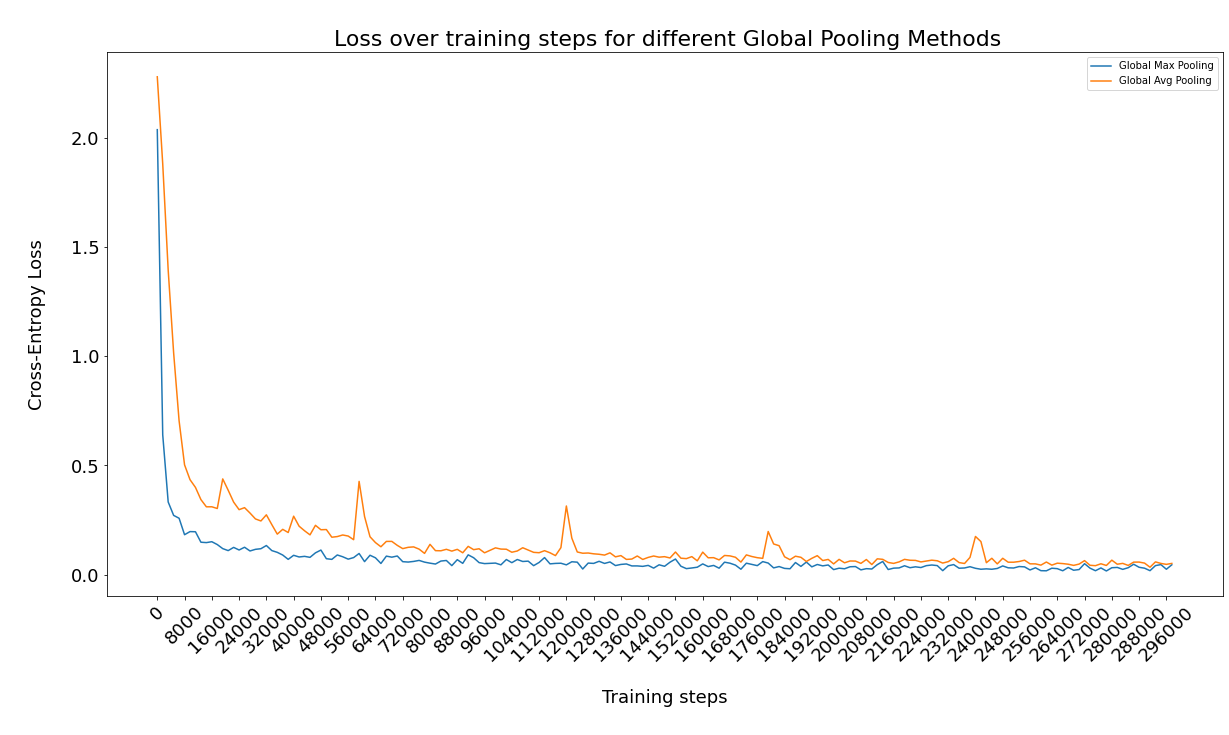

In [63]:
epochs = 5
window_size = 100

loss_histories = []
for init in ("max", "avg"):
    with open (f'loss_list_{init}.pkl', 'rb') as f:
        loss_history = pickle.load(f)
    windows = [loss_history[i:i+window_size] for i in range(0,len(loss_history)-window_size,window_size)]
    loss_avg = [sum(window)/window_size for window in windows]
    loss_histories.append(loss_avg)
    
plt.figure(figsize=(20,10))
plt.plot(loss_histories[0],label = "Global Max Pooling")
plt.plot(loss_histories[1],label = "Global Avg Pooling")
plt.legend()
ticks = [round(i/window_size) for i in range(0, len(loss_history) + 1, window_size*epochs)]
plt.xticks(ticks = ticks, labels = [tick * window_size * 16 for tick in ticks], size = 18, rotation = 45)
plt.yticks(size = 18)
plt.title("\n Loss over training steps for different Global Pooling Methods", size = 22)
plt.ylabel("\nCross-Entropy Loss\n", size = 18)
plt.xlabel("\nTraining steps\n", size = 18)
plt.legend()
plt.show

In [66]:
# Tuning learning rate and batch size for Q17

N = 80 
epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


for lr, bs in ((0.0005, 16), (0.0005, 32), (0.001, 16), (0.001, 32), (0.003, 16), (0.003, 32), (0.005, 16), (0.005, 32), (0.01, 16), (0.01, 32)):
    
    batch_size = bs

    net = Varres_Net(N, in_channels = 3, global_pool = "max")
    net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    running_correct = 0
    running_total = 0
    loss_list = []

    # Loop over variable resolutions
    for e in range(epochs):
        
        len_32, len_48, len_64 = len(imgs_32), len(imgs_48), len(imgs_64)
        size = len_32 + len_48 + len_64
        
        for batch in range(0, size, batch_size):
        
            # Select from correct Tensor according to iteration
            if batch < len_32:
                subset = batch
                imgs = imgs_32[subset : subset + batch_size,:,:,:]
                labels = labels_32[subset : subset + batch_size]
            elif batch >= len_32 and batch < len_32 + len_48:
                subset = batch - len_32
                imgs = imgs_48[subset : subset + batch_size,:,:,:]
                labels = labels_48[subset : subset + batch_size]
            elif batch >= len_32 + len_48 and batch < size:
                subset = batch - len_32 - len_48
                imgs = imgs_64[subset : subset + batch_size,:,:,:]
                labels = labels_64[subset : subset + batch_size]

            imgs, labels = imgs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()

            # Check performance
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if batch % 5000 == 0: # Print every 5000 batches
                current = batch * len(labels)
                print(f"loss: {loss:>7f}, accuracy: {running_correct / running_total :>5f} [{current:>5d}/{size:>5d}]")
        
    # Save Loss list
    with open(f'loss_list_{lr}_ {bs}.pkl', 'wb') as f:
        pickle.dump(loss_list, f)

    # Save Net
    PATH = f'./{lr}_{bs}_net.pth'
    torch.save(net.state_dict(), PATH)

    # Print final performance
    print(f"Accuracy and Loss with {lr} and {bs}: {running_correct / running_total}, {loss:>7f}")




loss: 2.264928, accuracy: 0.187500 [    0/60000]
loss: 0.351806, accuracy: 0.724241 [160000/60000]
loss: 0.108255, accuracy: 0.835624 [320000/60000]
loss: 0.074922, accuracy: 0.876170 [480000/60000]
loss: 0.023366, accuracy: 0.898605 [640000/60000]
loss: 0.004887, accuracy: 0.912883 [800000/60000]
loss: 0.074280, accuracy: 0.922903 [    0/60000]
loss: 0.170812, accuracy: 0.930431 [160000/60000]
loss: 0.004548, accuracy: 0.936234 [320000/60000]
loss: 0.078398, accuracy: 0.941241 [480000/60000]
loss: 0.003451, accuracy: 0.945033 [640000/60000]
loss: 0.001396, accuracy: 0.948331 [800000/60000]
loss: 0.002649, accuracy: 0.951120 [    0/60000]
loss: 0.068526, accuracy: 0.953834 [160000/60000]
loss: 0.002178, accuracy: 0.955873 [320000/60000]
loss: 0.034199, accuracy: 0.957975 [480000/60000]
loss: 0.002220, accuracy: 0.959668 [640000/60000]
loss: 0.001470, accuracy: 0.961253 [800000/60000]
loss: 0.001404, accuracy: 0.962611 [    0/60000]
loss: 0.013087, accuracy: 0.964011 [160000/60000]
loss

In [7]:
# Tuning learning rate and batch size for Q17 - Fixed Resolution network

N = 80 
epochs = 5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


for lr, bs in ((0.0005, 16), (0.0005, 32), (0.001, 16), (0.001, 32), (0.003, 16), (0.003, 32), (0.005, 16), (0.005, 32), (0.01, 16), (0.01, 32)):
    
    batch_size = bs

    transform = T.Compose(
        [T.Resize(size = (28,28)),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    lowres_trainset = torchvision.datasets.ImageFolder("/Users/maxfeucht/Documents/VU/Deep Learning/Assignments/Assignment3/mnist-varres/train", transform = transform)
    lowres_testset = torchvision.datasets.ImageFolder("/Users/maxfeucht/Documents/VU/Deep Learning/Assignments/Assignment3/mnist-varres/test", transform = transform)

    lowres_trainloader = torch.utils.data.DataLoader(lowres_trainset, batch_size=bs, shuffle=True, num_workers=4)
    lowres_testloader = torch.utils.data.DataLoader(lowres_testset, batch_size=bs, shuffle=True, num_workers=4)

    net = CNN(in_channels = 3)
    net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    running_total, running_correct = 0,0
    loss_list = []
    size = len(lowres_trainset)

    for e in range(epochs): 

        for batch, (imgs, labels) in enumerate(lowres_trainloader):

            imgs, labels = imgs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(imgs)
            loss = criterion(outputs, labels)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()

            # Check performance
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if batch % 1000 == 0: # Print every 5000 batches
                current = batch * len(labels)
                print(f"loss: {loss:>7f}, accuracy: {running_correct / running_total :>5f} [{current:>5d}/{size:>5d}]")
        
        # Save Loss list
        with open(f'loss_list_{lr}_ {bs}_fixed.pkl', 'wb') as f:
            pickle.dump(loss_list, f)

        # Save Net
        PATH = f'./{lr}_{bs}_net_fixed.pth'
        torch.save(net.state_dict(), PATH)

        # Print final performance
        print(f"Accuracy and Loss with {lr} and {bs}: {running_correct / running_total}, {loss:>7f}")



loss: 2.306014, accuracy: 0.062500 [    0/60000]
loss: 0.814476, accuracy: 0.582980 [16000/60000]
loss: 0.360811, accuracy: 0.711582 [32000/60000]
loss: 0.221666, accuracy: 0.770056 [48000/60000]
Accuracy and Loss with 0.0005 and 16: 0.7964833333333333, 0.222638
loss: 0.269969, accuracy: 0.796521 [    0/60000]
loss: 0.050429, accuracy: 0.823142 [16000/60000]
loss: 0.073533, accuracy: 0.842093 [32000/60000]
loss: 0.135849, accuracy: 0.856012 [48000/60000]
Accuracy and Loss with 0.0005 and 16: 0.864275, 0.229051
loss: 0.233187, accuracy: 0.864285 [    0/60000]
loss: 0.132101, accuracy: 0.874346 [16000/60000]
loss: 0.171107, accuracy: 0.882499 [32000/60000]
loss: 0.701811, accuracy: 0.889070 [48000/60000]
Accuracy and Loss with 0.0005 and 16: 0.8935, 0.106250
loss: 0.041544, accuracy: 0.893509 [    0/60000]
loss: 0.142706, accuracy: 0.899018 [16000/60000]
loss: 0.049571, accuracy: 0.903795 [32000/60000]
loss: 0.058282, accuracy: 0.907910 [48000/60000]
Accuracy and Loss with 0.0005 and 16:

# Testing the trained models on Testset

### Variable Resolution Net

In [12]:
# Load and evaluate Varres_Nets

for lr, bs in ((0.0005, 16), (0.0005, 32), (0.001, 16), (0.001, 32), (0.003, 16), (0.003, 32), (0.005, 16), (0.005, 32), (0.01, 16), (0.01, 32)):
    
    PATH = f'./{lr}_{bs}_net.pth'

    varres_model = Varres_Net(in_channels = 3, N = 80)
    varres_model.load_state_dict(torch.load(PATH))

    batch_size = bs
    
    test_len_32, test_len_48, test_len_64 = len(test_imgs_32), len(test_imgs_48), len(test_imgs_64)
    test_size = test_len_32 + test_len_48 + test_len_64
    num_batches = int(test_size / batch_size)

    criterion = nn.CrossEntropyLoss()
    test_loss, correct = 0, 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    varres_model.to(device)
    
    running_correct = 0
    running_total = 0
    
    with torch.no_grad():
        
        for batch in range(0, test_size, batch_size):
            
            # Select from correct Tensor according to iteration
            if batch < test_len_32:
                subset = batch
                imgs = test_imgs_32[subset : subset + batch_size,:,:,:]
                labels = test_labels_32[subset : subset + batch_size]
            elif batch >= test_len_32 and batch < test_len_32 + test_len_48:
                subset = batch - test_len_32
                imgs = test_imgs_48[subset : subset + batch_size,:,:,:]
                labels = test_labels_48[subset : subset + batch_size]
            elif batch >= test_len_32 + test_len_48 and batch < size:
                subset = batch - test_len_32 - test_len_48
                imgs = test_imgs_64[subset : subset + batch_size,:,:,:]
                labels = test_labels_64[subset : subset + batch_size]
        
            imgs, labels = imgs.to(device), labels.to(device)
            pred = varres_model(imgs)
            loss = criterion(pred, labels)           
            _, predicted = torch.max(pred.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
               
        print(f"With lr {lr} and batch size {bs}: loss: {loss:>7f}, accuracy: {running_correct / running_total :>5f}")

With lr 0.0005 and batch size 16: loss: 0.044525, accuracy: 0.979565
With lr 0.0005 and batch size 32: loss: 0.046753, accuracy: 0.985853
With lr 0.001 and batch size 16: loss: 0.001682, accuracy: 0.983372
With lr 0.001 and batch size 32: loss: 0.013223, accuracy: 0.977927
With lr 0.003 and batch size 16: loss: 0.019004, accuracy: 0.976260
With lr 0.003 and batch size 32: loss: 0.000393, accuracy: 0.982643
With lr 0.005 and batch size 16: loss: 0.000285, accuracy: 0.977963
With lr 0.005 and batch size 32: loss: 0.000579, accuracy: 0.981940
With lr 0.01 and batch size 16: loss: 0.041926, accuracy: 0.943504
With lr 0.01 and batch size 32: loss: 0.011570, accuracy: 0.966289


### Fixed Low Resolution Net

In [15]:
# Load and evaluate Fixed Nets
  
for lr, bs in ((0.0005, 16), (0.0005, 32), (0.001, 16), (0.001, 32), (0.003, 16), (0.003, 32), (0.005, 16), (0.005, 32), (0.01, 16), (0.01, 32)):
        
    PATH = f'./{lr}_{bs}_net_fixed.pth'

    fixed_model = CNN(in_channels = 3)
    fixed_model.load_state_dict(torch.load(PATH))

    batch_size = bs
    num_batches = int(test_size / batch_size)

    criterion = nn.CrossEntropyLoss()
    test_loss, correct = 0, 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fixed_model.to(device)
    
    running_correct = 0
    running_total = 0
    
    lowres_testloader = torch.utils.data.DataLoader(lowres_testset, batch_size=bs, shuffle=True, num_workers=4)

    with torch.no_grad():
        
        for imgs, labels in lowres_testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            pred = fixed_model(imgs)
            loss = criterion(pred, labels)           
            _, predicted = torch.max(pred.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
               
        print(f"With lr {lr} and batch size {bs}: loss: {loss:>7f}, accuracy: {running_correct / running_total :>5f}")
        

With lr 0.0005 and batch size 16: loss: 0.043225, accuracy: 0.971000
With lr 0.0005 and batch size 32: loss: 0.004736, accuracy: 0.967900
With lr 0.001 and batch size 16: loss: 0.000856, accuracy: 0.972500
With lr 0.001 and batch size 32: loss: 0.017065, accuracy: 0.969900
With lr 0.003 and batch size 16: loss: 0.000870, accuracy: 0.955200
With lr 0.003 and batch size 32: loss: 0.095368, accuracy: 0.968700
With lr 0.005 and batch size 16: loss: 0.007167, accuracy: 0.945900
With lr 0.005 and batch size 32: loss: 0.018458, accuracy: 0.930900
With lr 0.01 and batch size 16: loss: 0.552128, accuracy: 0.876100
With lr 0.01 and batch size 32: loss: 2.292702, accuracy: 0.113500
